## Import Libraries

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, get_window
from scipy import signal
from scipy.io import wavfile
from scipy.signal import firwin
import soundfile as sf

import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from scipy.signal import spectrogram
from scipy.signal import filtfilt, lfilter
from IPython.display import Audio
from IPython.display import Audio
from scipy.signal import butter, freqz

from scipy.signal import butter

## Helper Functions

In [2]:
def normalize(y):
    y = y.astype(float)
    y /= np.max(np.abs(y))
    return y

def plot_spectrogram(y, fs):
    # y = y.astype(float)
    # y /= np.max(np.abs(y))
    
    # Compute spectrogram
    f, t, Sxx = spectrogram(y, fs=fs, window='hann')
    
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
    plt.title('Spectrogram (dB)')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.colorbar(label='Power [dB]')
    plt.ylim(0, 7000)
    plt.tight_layout()
    plt.show()

def listen(y, fs):
    Audio(y, rate=fs)

def fft_plot(y, fs):
    Y = np.fft.fft(y)
    N = len(Y)
    freq = np.fft.fftfreq(N, 1/fs)
    
    magnitude = np.abs(Y) / N        
    half = N // 2                    
    
    # Plot the spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(freq, magnitude)
    plt.title("Fourier Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.xlim(0, 5000)
    plt.show()

def iir_filter(fl, fh, order, fs):
    nyq = 0.5 * fs
    low = fl / nyq
    high = fh / nyq
    
    b, a = butter(order, [low, high], btype='band')
    return [b, a]

def fir_filter(lf, hf, numtaps, fs):
    filter_fir = firwin(numtaps, [lf, hf], fs=fs, pass_zero=False)
    return filter_fir

## Input Clean Signal

In [3]:
# Read the WAV file
fs, data1 = wavfile.read('record.wav')

if data1.ndim == 2:
    data = np.mean(data1, axis=1).astype(data1.dtype)  # Convert to mono
else:
    data = data1

data = normalize(data)
print("Sample rate:", fs)
Audio(data, rate=fs)

Sample rate: 48000


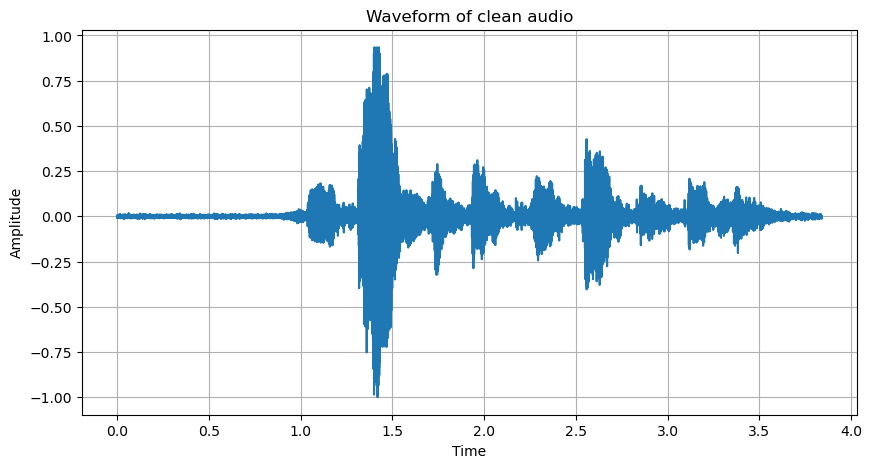

In [4]:
t = np.arange(len(data)) / fs
plt.figure(figsize=(10, 5))
plt.plot(t, data)
plt.title("Waveform of clean audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

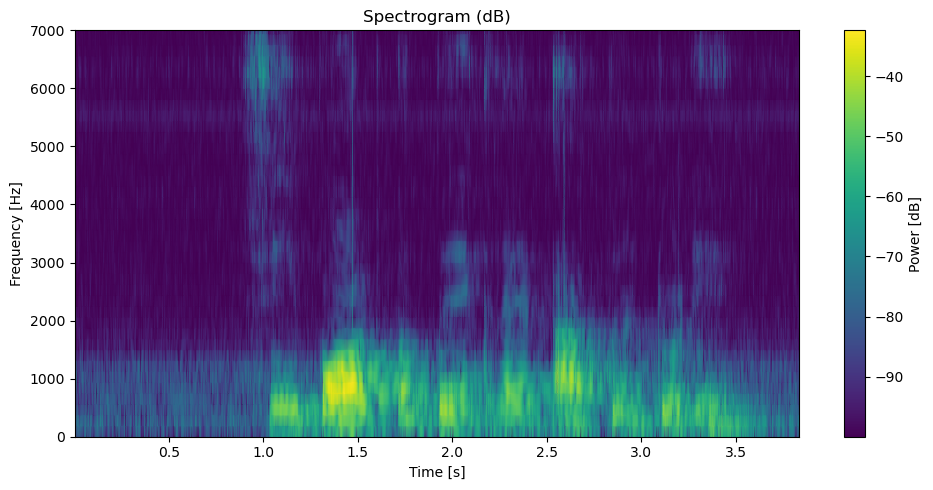

In [5]:
plot_spectrogram(data, fs)

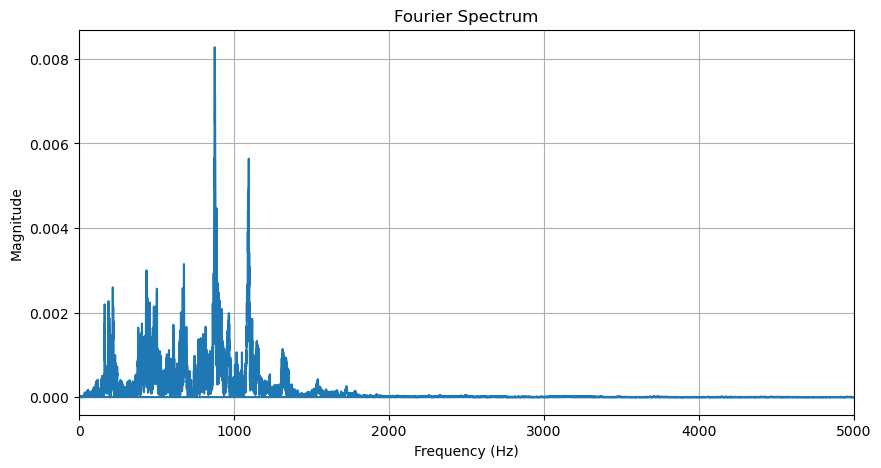

In [6]:
fft_plot(data, fs)

### Adding Noise

In [26]:
noise_strength = 0.02  
noise = noise_strength * np.random.normal(0, 1, size=data.shape)

noisy_data = data + noise
noisy_data = np.clip(noisy_data, -1, 1)

sf.write('noisy_out.wav', noisy_data, fs, subtype='PCM_16')
Audio(noisy_data, rate=fs)

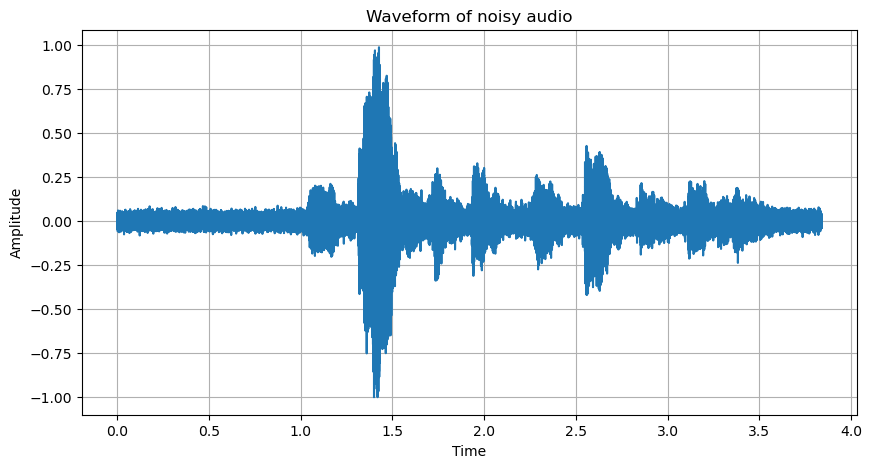

In [8]:
t = np.arange(len(data)) / fs
plt.figure(figsize=(10, 5))
plt.plot(t, noisy_data)
plt.title("Waveform of noisy audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

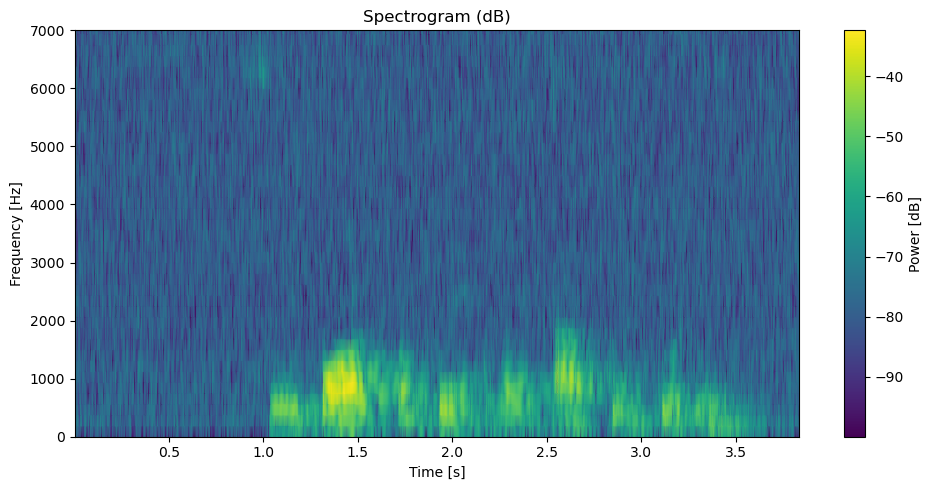

In [9]:
plot_spectrogram(noisy_data, fs)

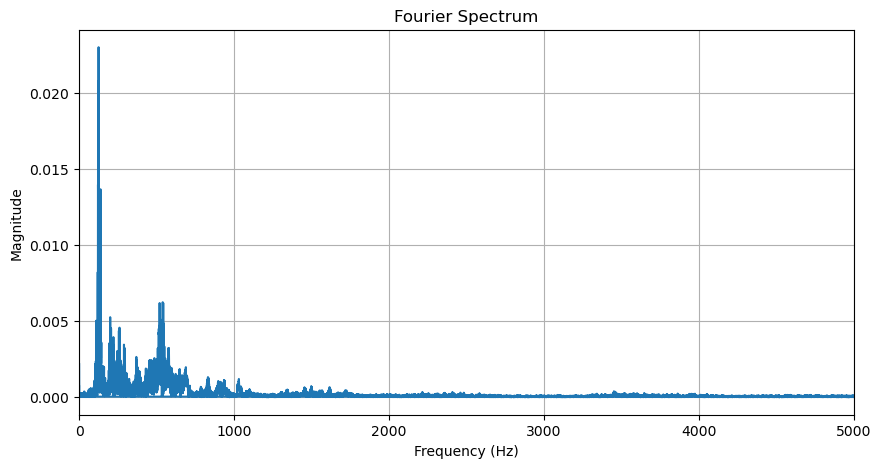

In [148]:
fft_plot(noisy_data, fs)

### Filtering

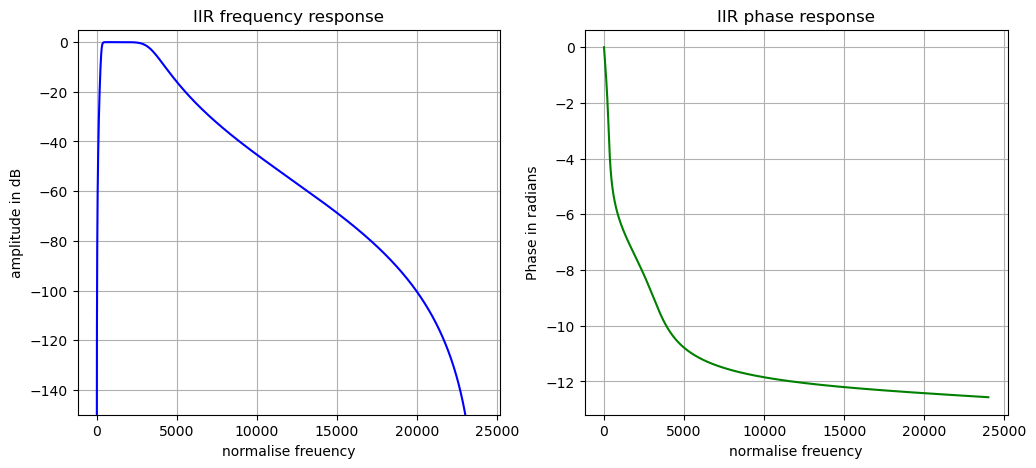

In [11]:
# IIR FILTER DESIGN

iir_coeffs = iir_filter(300, 3400, 4, fs)
nyq = fs / 2
w, h = freqz(iir_coeffs[0], iir_coeffs[1], worN=8000)
freqs = w * nyq / np.pi

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(freqs, 20*np.log10(abs(h)), 'b')
plt.title("IIR frequency response")
plt.xlabel("normalise freuency")
plt.ylabel("amplitude in dB")
plt.ylim(-150, 5)
plt.grid(True)

plt.subplot(1, 2, 2)
phase = np.unwrap(np.angle(h))
plt.plot(freqs, phase, 'g')
plt.title("IIR phase response")
plt.xlabel("normalise freuency")
plt.ylabel("Phase in radians")
plt.grid(True)

In [27]:
iir_filtered = filtfilt(iir_coeffs[0], iir_coeffs[1], noisy_data)
sf.write('iir_filtered.wav', iir_filtered, fs, subtype='PCM_16')
Audio(iir_filtered, rate=fs)

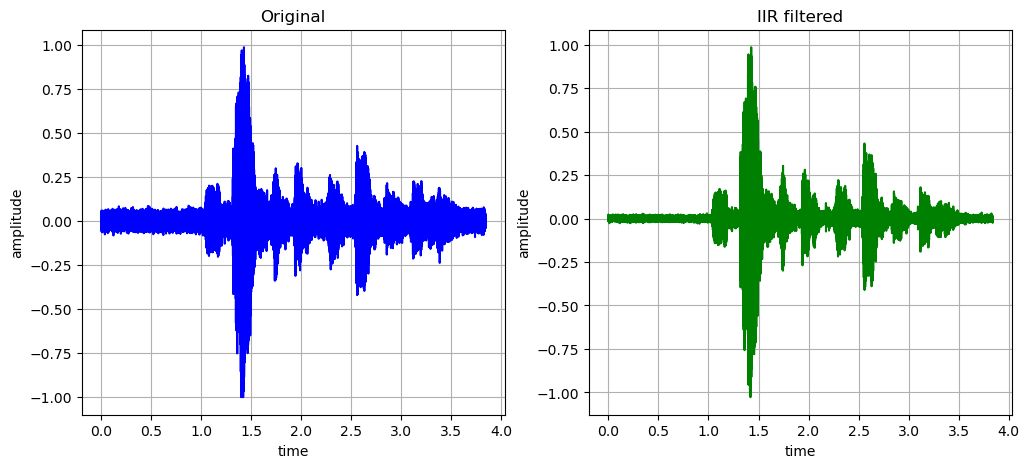

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t, noisy_data, 'b')
plt.title("Original")
plt.xlabel("time")
plt.ylabel("amplitude")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t, iir_filtered, 'g')
plt.title("IIR filtered")
plt.xlabel("time")
plt.ylabel("amplitude")
plt.grid(True)

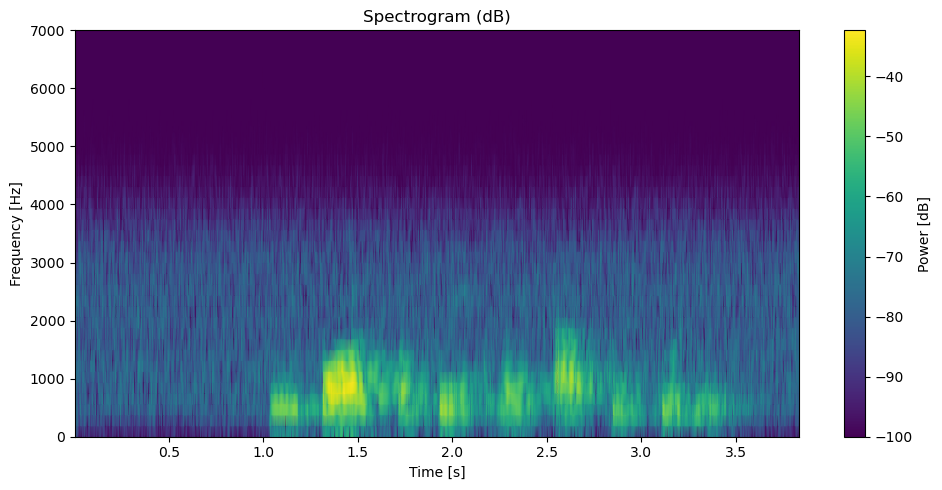

In [14]:
plot_spectrogram(iir_filtered, fs)

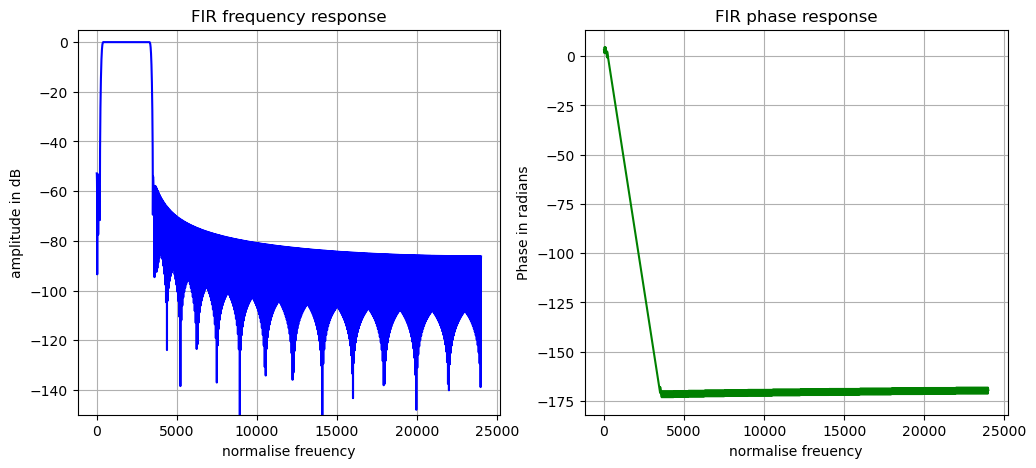

In [15]:
# FIR FILTER DESIGN
fir_coeffs = fir_filter(300, 3400, 801, fs)
w, h = freqz(fir_coeffs, 1.0, worN=8000)
freqs = w * nyq / np.pi

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(freqs, 20*np.log10(abs(h)), 'b')
plt.title("FIR frequency response")
plt.xlabel("normalise freuency")
plt.ylabel("amplitude in dB")
plt.ylim(-150, 5)
plt.grid(True)

plt.subplot(1, 2, 2)
phase = np.unwrap(np.angle(h))
plt.plot(freqs, phase, 'g')
plt.title("FIR phase response")
plt.xlabel("normalise freuency")
plt.ylabel("Phase in radians")
plt.grid(True)



In [28]:
fir_filtered = filtfilt(fir_coeffs, 1.0, noisy_data)
sf.write('fir_filtered.wav', fir_filtered, fs, subtype='PCM_16')
Audio(fir_filtered, rate=fs)

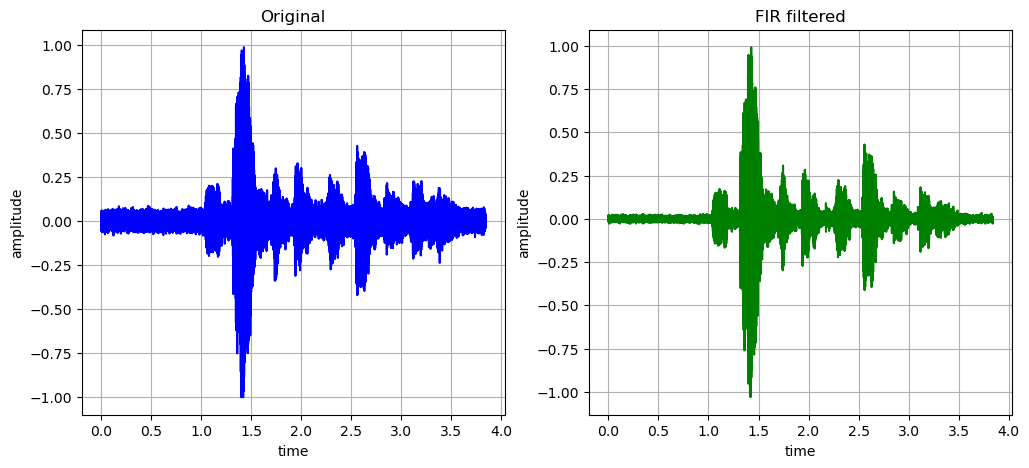

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t, noisy_data, 'b')
plt.title("Original")
plt.xlabel("time")
plt.ylabel("amplitude")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t, fir_filtered, 'g')
plt.title("FIR filtered")
plt.xlabel("time")
plt.ylabel("amplitude")
plt.grid(True)

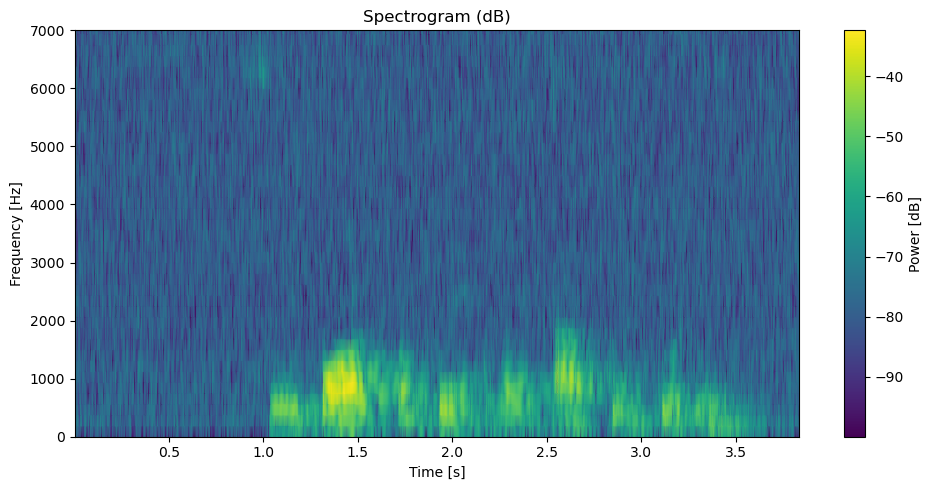

In [18]:
plot_spectrogram(noisy_data, fs)

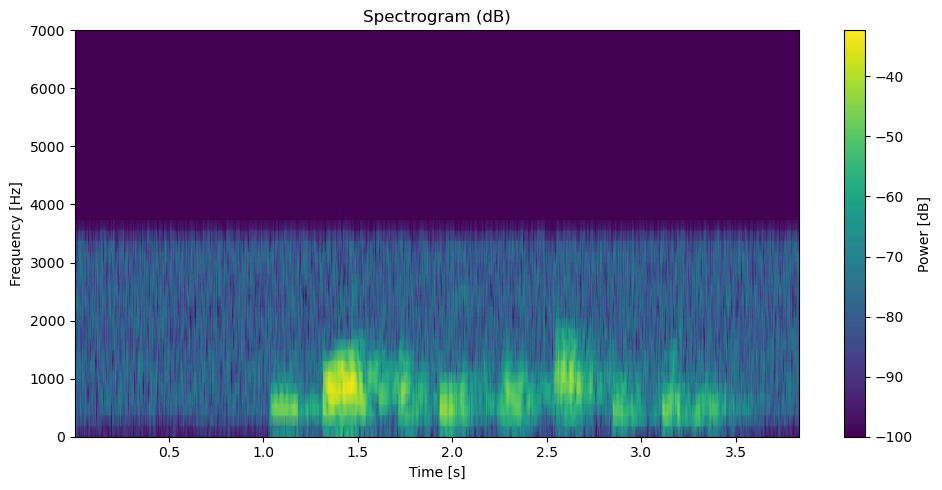

In [19]:
plot_spectrogram(fir_filtered, fs)

### SNR Comparison

In [23]:
def compute_snr(clean, test):
    noise = clean - test
    snr = 10 * np.log10(np.mean(clean**2) / np.mean(noise**2))
    return snr

data_bandpassed_fir = filtfilt(fir_coeffs, [1.0], data)
data_bandpassed_iir = filtfilt(iir_coeffs[0], iir_coeffs[1], data)

snr_fir = compute_snr(data_bandpassed_fir, fir_filtered)
snr_iir = compute_snr(data_bandpassed_iir, iir_filtered)
snr_noisy = compute_snr(data, noisy_data)

print("SNR Of Noisy Signal: ",snr_noisy)
print("SNR Of IIR Filtered Signal: ",snr_iir)
print("SNR Of FIR Filtered Signal: ",snr_fir)

SNR Of Noisy Signal:  13.744790199683862
SNR Of IIR Filtered Signal:  22.836948922233713
SNR Of FIR Filtered Signal:  22.51101066082708
